# Question we are trying to answer:

Throwing deep passes is more valuable than short passes, but it’s difficult to say whether or not a quarterback is good at deep passes.

A question that will help us determine stable versus unstable QB stats. It is a reasonable hypothesis, but to make it scientific, you need to define what “valuable” means and what you mean when we say a player is “good” (or “bad”) at deep passes. To that aim, you need data.


In [1]:
import pandas as pd

In [2]:
import numpy as np

In [3]:
np.float_ = np.float64

In [4]:
import nfl_data_py as nfl

In [5]:
pbp_py = nfl.import_pbp_data(range(2016, 2022 + 1))

2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
Downcasting floats.


Here, play_type being equal to pass will eliminate both running plays and plays that are negated because of a penalty. Sometimes you want to include plays that have a penalty (for example, if you are using a grade-based system like the one at PFF). Grade-based systems attempt to measure how well the player performed on a play independent of the final statistics of the play, so keeping data where play_type == no_play might have value.

For the sake of this exercise, though, we have you omit such plays. You also omit plays where air_yards is NA (in R) or NULL (in Python). These plays occur when a pass is not aimed at an intended receiver because it’s batted down at the line of scrimmage, thrown away, or spiked. While those passes certainly count toward a passer’s final statistics, and are fundamental to who he is as a player, they are not necessarily relevant to the question being asking here.

In [6]:
pbp_py_p = (pbp_py
            .query("play_type == 'pass' & air_yards.notnull()")
            .reset_index())

First, define a long pass as a pass that has air yards greater than or equal to 20 yards, and a short pass as one with air yards less than 20 yards.

In [7]:
pbp_py_p['pass_length_air_yards'] = np.where(
    pbp_py_p['air_yards'] >= 20, 'long', 'short'
)

Second, the passing yards for incomplete passes are recorded as NULL in Python, but should be set to 0 for this analysis. In Python, the numpy (imported as np) package’s where() function helps with these changes.

In [8]:
pbp_py_p['passing_yards'] = np.where(
    pbp_py_p['passing_yards'].isnull(), 0, pbp_py_p['passing_yards']
)

pbp_py_p['passing_yards'].describe()

In [9]:
pbp_py_p.query('pass_length_air_yards == "short"')["passing_yards"]\
    .describe()

count    116087.000000
mean          6.526777
std           7.699158
min         -20.000000
25%           0.000000
50%           5.000000
75%          10.000000
max          95.000000
Name: passing_yards, dtype: float64

In [10]:
pbp_py_p.query('pass_length_air_yards == "long"')["passing_yards"]\
    .describe()

count    15520.000000
mean        12.173261
std         17.925947
min          0.000000
25%          0.000000
50%          0.000000
75%         26.000000
max         98.000000
Name: passing_yards, dtype: float64

Basically what these numbers are showing is the difference in various metrics for pass yards completed when throwing a short pass compared to a long one.

The point to notice here is that the interquartile range, the difference between the first and third quartile, is much larger for longer passes than for short passes, even though the maximum passing yards are about the same.

In [11]:
pbp_py_p\
    .query('pass_length_air_yards == "short"')["epa"]\
    .describe()

count    116086.000000
mean          0.119740
std           1.426228
min         -13.031219
25%          -0.606098
50%          -0.002116
75%           0.959173
max           8.241420
Name: epa, dtype: float64

In [12]:
pbp_py_p\
    .query('pass_length_air_yards == "long"')["epa"]\
    .describe()

count    15520.000000
mean         0.382845
std          2.185511
min        -10.477921
25%         -0.827297
50%         -0.464970
75%          2.135163
max          8.789743
Name: epa, dtype: float64

You get the same dynamic here: wider outcomes for longer passes than shorter ones. Longer passes are more variable than shorter passes.

Furthermore, if you look at the mean passing yards per attempt (YPA) and EPA per attempt for longer passes, they are both higher than those for short passes (while the relationship flips for the median, why is that?) (if I had to guess, it could either be there are more interceptions thrown on long passes or that the opportunity cost for long passes is greater). Thus, on average, you can informally confirm the first part of our guiding hypothesis for the chapter: “Throwing deep passes is more valuable than short passes, but it’s difficult to say whether or not a quarterback is good at deep passes.”

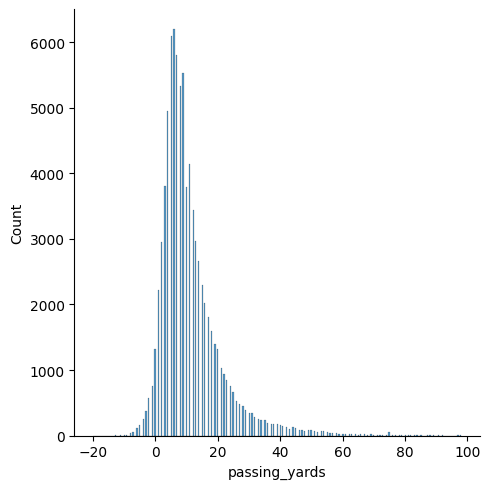

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.displot(data=pbp_py, x="passing_yards")

Passing yards gained ranges from about –10 yards to about 75 yards, with most plays gaining between 0 (often an incompletion) and 10 yards.

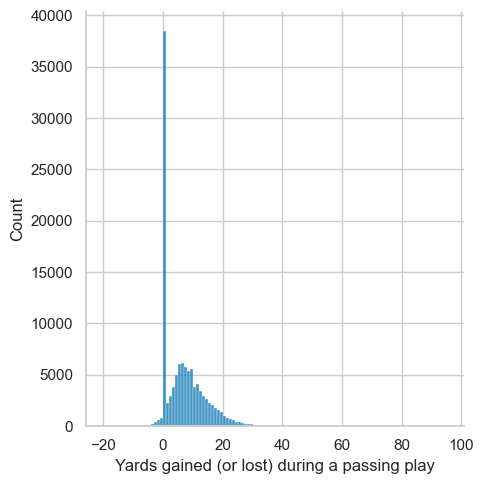

In [14]:
sns.set_theme(style="whitegrid", palette="colorblind")

pbp_py_p_short = \
    pbp_py_p\
    .query('pass_length_air_yards == "short"')

pby_py_hist_short = \
    sns.displot(
        data=pbp_py_p_short,
        binwidth=1,
        x='passing_yards'
    );
pby_py_hist_short\
    .set_axis_labels(
        "Yards gained (or lost) during a passing play", "Count"
    );
plt.show();

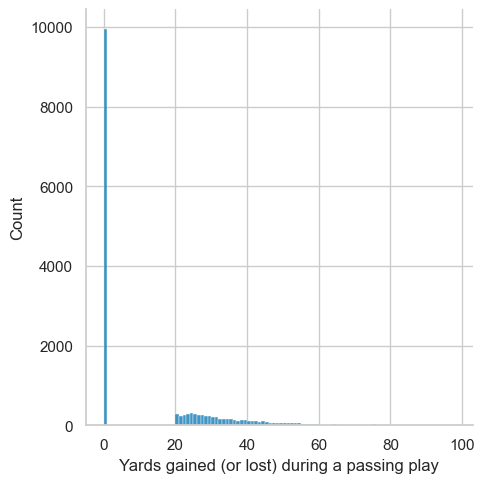

In [15]:
pbp_py_p_long = \
    pbp_py_p\
    .query('pass_length_air_yards == "long"')

pby_py_hist_long = \
    sns.displot(
        data=pbp_py_p_long,
        binwidth=1,
        x='passing_yards'
    );
pby_py_hist_long\
    .set_axis_labels(
        "Yards gained (or lost) during a passing play", "Count"
    );
plt.show();

These histograms represent pictorially what you saw numerically in “Summarizing Data”. Specifically, shorter passes have fewer variable outcomes than longer passes.

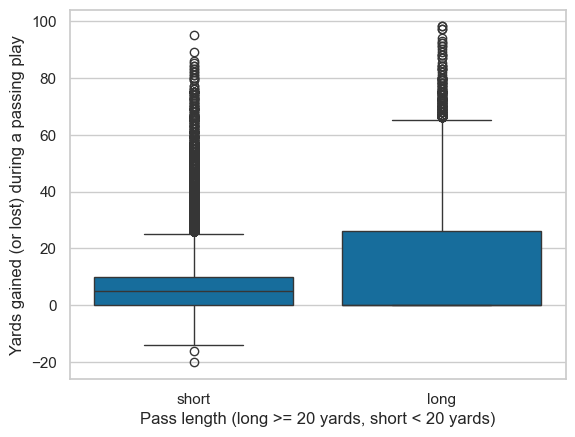

In [16]:
pass_boxplot = \
    sns.boxplot(data=pbp_py_p,
                x="pass_length_air_yards",
                y="passing_yards");
pass_boxplot.set(
    xlabel="Pass length (long >= 20 yards, short < 20 yards)",
    ylabel="Yards gained (or lost) during a passing play",
);
plt.show();

For long passes, the reason why there is no line in the middle of the box is because the median is actually 0 yards (if you think about it, a lot of long passes are incompletions)

Now that you’ve become acquainted with our data, it’s time to use it for player evaluation. The first thing you have to do is aggregate across a prespecified time frame to get a value for each player. While week-level outputs certainly matter, especially for fantasy football and betting (see Chapter 7), most of the time when teams are thinking about trying to acquire a player, they use season-level data (or sometimes data over many seasons).

Thus, you aggregate at the season level here, by using the grouby() syntax in Python or group_by() syntax in R. The group by concept borrows from SQL-type database languages. When thinking about the process here, group by may be thought of as a verb. For example, you use the play-by-play data and then group by the seasons and then aggregate (in Python) or summarize (in R) to calculate the mean of the quarterback’s passing YPA.

For this problem, take the play-by-play dataframe (pbp_py) and then group by passer_id, passer, season, and pass_length. Group by both the player ID and the player name column because some players have the same name (or at least same first initial and last name), but the name is important for studying the results of the analysis. Start with the whole dataset first before transitioning to the subsets.

In Python, use groupby() with a list of the variables that you want to group by. Then aggregate the data for passing_yards for the mean:

Collapse the columns by using list(map()). map() iterates over items.

Then rename the columns to names that are shorter/more intuitive.

Then view the top of the dataframe by sorting by ypa from high to low (ascending=False)

In [17]:
pbp_py_p_seasons =\
    pbp_py_p\
    .groupby(["passer_id", "passer", "posteam", "season"])\
    .agg({"passing_yards": ["mean", "count"]})
pbp_py_p_seasons.columns = list(map("_".join, pbp_py_p_seasons.columns.values))
pbp_py_p_seasons\
    .rename(columns={'passing_yards_mean': 'ypa',
                     'passing_yards_count': 'n'},
           inplace=True)
pbp_py_p_seasons\
    .sort_values(by=["ypa"], ascending=False)\
    .head()

,,,,ypa,n
passer_id,passer,posteam,season,,
00-0035544,T.Kennedy,DET,2021,75.0,1
00-0033132,K.Byard,TEN,2018,66.0,1
00-0031235,O.Beckham,NYG,2018,53.0,2
00-0030669,A.Wilson,MIA,2018,52.0,1
00-0029632,M.Sanu,ATL,2017,51.0,1


Now this isn’t really informative yet, since the players with the highest YPA values are players who threw a pass or two (usually a trick play) that were completed for big yardage. Fix this by filtering for a certain number of passing attempts in a season (let’s say 100) and see what you get.

In Python, reuse pbp_py_p_s and the previous code, but include a query() for players with 100 or more pass attempts by using 'n >= 100':

In [18]:
pbp_py_p_s_100 = \
    pbp_py_p_seasons\
    .query("n >= 100")\
    .sort_values(by=["ypa"], ascending=False)
pbp_py_p_s_100.head(20)

,,,,ypa,n
passer_id,passer,posteam,season,,
00-0023682,R.Fitzpatrick,TB,2018,9.617887,246
00-0026143,M.Ryan,ATL,2016,9.442155,631
00-0029701,R.Tannehill,TEN,2019,9.069971,343
00-0033537,D.Watson,HOU,2020,8.898524,542
00-0036212,T.Tagovailoa,MIA,2022,8.892231,399
00-0031345,J.Garoppolo,SF,2017,8.863636,176
00-0033873,P.Mahomes,KC,2018,8.709678,651
00-0036442,J.Burrow,CIN,2021,8.673748,659
00-0026498,M.Stafford,DET,2019,8.647058,289


In [19]:
pbp_py.columns

Index(['play_id', 'game_id', 'old_game_id', 'home_team', 'away_team',
       'season_type', 'week', 'posteam', 'posteam_type', 'defteam',
       ...
       'offense_players', 'defense_players', 'n_offense', 'n_defense',
       'ngs_air_yards', 'time_to_throw', 'was_pressure', 'route',
       'defense_man_zone_type', 'defense_coverage_type'],
      dtype='object', length=390)

## Deep Passes Versus Short Passes 
Now, down to the business of the chapter, testing the second part of the hypothesis: “Throwing deep passes is more valuable than short passes, but it’s difficult to say whether or not a quarterback is good at deep passes.” For this stability analysis, do the following steps:

Calculate the YPA for each passer for each season.

Calculate the YPA for each passer for the previous season.

Look at the correlation from the values calculated in steps 1 and 2 to see the stability.

Use similar code as before, but include pass_length_air_yards with the group by commands to include pass yards. With this operation, naming becomes hard.

We have you use the dataset (play-by-play, pbp), the language (either Python, _py, or R, _r), passing plays (_p), seasons data (_s), and finally, pass length (_pl).

For both languages, you will create a copy of the dataframe and then shift the year by adding 1. Then you’ll merge the new dataframe with the original dataframe. This will let you have the current and previous year’s values.

In [20]:
pbp_py_p_s_pl = \
    pbp_py_p\
    .groupby(["passer_id", "passer", "season", "pass_length_air_yards"])\
    .agg({"passing_yards": ["mean", "count"]})
pbp_py_p_s_pl.columns =\
    list(map("_".join, pbp_py_p_s_pl.columns.values))
pbp_py_p_s_pl\
    .rename(columns={'passing_yards_mean': 'ypa',
                     'passing_yards_count': 'n'},
            inplace=True)
pbp_py_p_s_pl.reset_index(inplace=True)

Select only short-passing data from passers with more than 100 such plays and long-passing data for passers with more than 30 such plays:

In [21]:
q_value = (
    '(n >= 100 & ' +
     'pass_length_air_yards == "short") | ' +
     '(n >= 30 & ' +
     'pass_length_air_yards == "long")'
)
pbp_py_p_s_pl = pbp_py_p_s_pl.query(q_value).reset_index()

Then create a list of columns to save (cols_save) and a new dataframe with only these columns (air_yards_py). Include a .copy() so edits will not be passed back to the original dataframe:

In [22]:
cols_save =\
    ["passer_id", "passer", "season",
     "pass_length_air_yards", "ypa"]
air_yards_py =\
    pbp_py_p_s_pl[cols_save].copy()

Next, copy air_yards_py to create air_yards_lag_py. Take the current season value and add 1 by using the shortcut command += and rename the passing_yards_mean to include last (which refers to the one-year offset or delay between the two years):

In [23]:
# This will set a ypa_last column where it holds the ypa of the previous season (season: 2018, ypa_last: ypa_2017)
air_yards_lag_py =\
    air_yards_py.copy()
air_yards_lag_py["season"] += 1
air_yards_lag_py\
    .rename(columns={'ypa': 'ypa_last'},
           inplace=True)

In [24]:
air_yards_py.head

<bound method NDFrame.head of       passer_id      passer  season pass_length_air_yards        ypa
0    00-0019596     T.Brady    2016                  long  15.768116
1    00-0019596     T.Brady    2016                 short   7.163022
2    00-0019596     T.Brady    2017                  long  13.264706
3    00-0019596     T.Brady    2017                 short   7.071429
4    00-0019596     T.Brady    2018                  long  10.232877
..          ...         ...     ...                   ...        ...
498  00-0037327  S.Thompson    2022                 short   4.664122
499  00-0037834     B.Purdy    2022                 short   7.720588
500  00-0038102   K.Pickett    2022                  long  11.325582
501  00-0038102   K.Pickett    2022                 short   5.556522
502  00-0038122    D.Ridder    2022                 short   6.068627

[503 rows x 5 columns]>

In [25]:
air_yards_lag_py.head

<bound method NDFrame.head of       passer_id      passer  season pass_length_air_yards   ypa_last
0    00-0019596     T.Brady    2017                  long  15.768116
1    00-0019596     T.Brady    2017                 short   7.163022
2    00-0019596     T.Brady    2018                  long  13.264706
3    00-0019596     T.Brady    2018                 short   7.071429
4    00-0019596     T.Brady    2019                  long  10.232877
..          ...         ...     ...                   ...        ...
498  00-0037327  S.Thompson    2023                 short   4.664122
499  00-0037834     B.Purdy    2023                 short   7.720588
500  00-0038102   K.Pickett    2023                  long  11.325582
501  00-0038102   K.Pickett    2023                 short   5.556522
502  00-0038122    D.Ridder    2023                 short   6.068627

[503 rows x 5 columns]>

Finally, merge() the two dataframes together and use an inner join so only shared years will be saved and join on passer_id, passer, season, and pass_length_air_yards:

In [26]:
# Allows us to merge air and air_lag to have ypa and ypa_last on one row for each QB
pbp_py_p_s_pl =\
    air_yards_py\
    .merge(air_yards_lag_py,
           how='inner',
           on=['passer_id', 'passer',
               'season', 'pass_length_air_yards'])

Check the results of your choice in Python by examining a couple of quarterbacks of your choice such as Patrick Mahomes (P.Mahomes) and Lamar Jackson (L.Jackson) and include only the necessary columns to have an easier-to-view dataframe:

In [27]:
print(
    pbp_py_p_s_pl[["pass_length_air_yards", "passer",
                    "season", "ypa", "ypa_last"]]\
    .query('passer == "P.Mahomes" | passer == "L.Jackson"')\
    .sort_values(["passer", "pass_length_air_yards", "season"])\
    .to_string()
)

    pass_length_air_yards     passer  season        ypa   ypa_last
249                  long  L.Jackson    2020  12.365385  11.455882
251                  long  L.Jackson    2021  10.703704  12.365385
253                  long  L.Jackson    2022   9.121951  10.703704
248                 short  L.Jackson    2019   6.974293   6.333333
250                 short  L.Jackson    2020   6.671196   6.974293
252                 short  L.Jackson    2021   7.111111   6.671196
254                 short  L.Jackson    2022   6.577465   7.111111
238                  long  P.Mahomes    2019  17.012196  14.627451
240                  long  P.Mahomes    2020  11.101266  17.012196
242                  long  P.Mahomes    2021  14.011765  11.101266
244                  long  P.Mahomes    2022  14.523809  14.011765
239                 short  P.Mahomes    2019   6.881323   7.610200
241                 short  P.Mahomes    2020   7.552885   6.881323
243                 short  P.Mahomes    2021   6.769784   7.55

In [28]:
print(
    pbp_py_p_s_pl[["pass_length_air_yards", "passer",
                    "season", "ypa", "ypa_last"]]\
    .query('passer == "T.Brady" | passer == "A.Rodgers"')\
    .sort_values(["passer", "pass_length_air_yards", "season"])\
    .to_string()
)

   pass_length_air_yards     passer  season        ypa   ypa_last
47                  long  A.Rodgers    2019  12.092592  12.011628
49                  long  A.Rodgers    2020  16.097826  12.092592
51                  long  A.Rodgers    2021  14.302631  16.097826
53                  long  A.Rodgers    2022  10.312500  14.302631
45                 short  A.Rodgers    2017   6.041475   6.693523
46                 short  A.Rodgers    2018   6.697446   6.041475
48                 short  A.Rodgers    2019   6.207224   6.697446
50                 short  A.Rodgers    2020   6.718447   6.207224
52                 short  A.Rodgers    2021   6.777083   6.718447
54                 short  A.Rodgers    2022   6.239130   6.777083
0                   long    T.Brady    2017  13.264706  15.768116
2                   long    T.Brady    2018  10.232877  13.264706
4                   long    T.Brady    2019  10.828571  10.232877
6                   long    T.Brady    2020  12.252101  10.828571
8         

In [29]:
pbp_py_p_s_pl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315 entries, 0 to 314
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   passer_id              315 non-null    object 
 1   passer                 315 non-null    object 
 2   season                 315 non-null    int64  
 3   pass_length_air_yards  315 non-null    object 
 4   ypa                    315 non-null    float32
 5   ypa_last               315 non-null    float32
dtypes: float32(2), int64(1), object(3)
memory usage: 12.4+ KB


The seven columns contain the following data:

* passer_id is the unique passer identification number for the player.

* passer is the (potentially) nonunique first initial and last name for the passer.

* posteam is the team the QB is playing on

* pass_length_air_yards is the type of pass (either long or short) you defined earlier.

* season is the final season in the season pair (e.g., season being 2017 means you’re comparing 2016 and 2017).

* ypa is the yards per attempt during the stated season (e.g., 2017 in the previous example).

* ypa_last is the yards per attempt during the season previous to the stated season (e.g., 2016 in the previous example).

Now that we’ve reminded ourselves what’s in the data, let’s dig in and see how many quarterbacks you have. With Python, use the passer_id column and find the unique() values and then find the length of this object:

In [30]:
len(pbp_py_p_s_pl.passer_id.unique())

65

You now have a decent sample size of quarterbacks. You can plot this data by using a scatterplot. Scatterplots plot points on a figure, which is in contrast to histograms that plot bins of data and to boxplots that plot summaries of the data such as medians. Scatterplots allow you to “see” the data directly. The horizontal axis is called the x-axis and typically includes the predictor, or causal, variable, if one exists. The vertical axis is called the y-axis and typically includes the response, or effect, variables, if one exists. With our example, you will use the YPA from the previous year as the predictor for YPA in the current year.

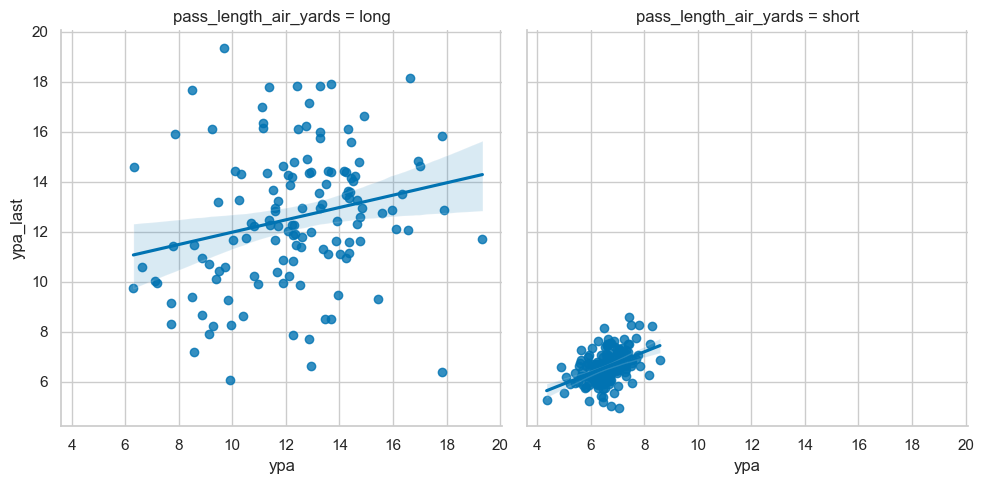

In [31]:
sns.lmplot(data=pbp_py_p_s_pl,
           x="ypa",
           y="ypa_last",
           col="pass_length_air_yards");
plt.show();

In [32]:
# filter out null values
# group by long or short passes and look at the correlation between ypa and ypa_last
pbp_py_p_s_pl\
    .query("ypa.notnull() & ypa_last.notnull()")\
    .groupby("pass_length_air_yards")[["ypa", "ypa_last"]]\
    .corr()

ypa  ypa_last
pass_length_air_yards                             
long                  ypa       1.000000  0.232828
                      ypa_last  0.232828  1.000000
short                 ypa       1.000000  0.440016
                      ypa_last  0.440016  1.000000

While both datasets include a decent amount of noise, vis-à-vis Pearson’s correlation coefficient, a quarterback’s performance on shorter passes is twice as stable as on longer passes. Thus, you can confirm the second part of the guiding hypothesis of the chapter: “Throwing deep passes is more valuable than short passes, but it’s difficult to say whether or not a quarterback is good at deep passes.”

A Pearson’s correlation coefficient can vary from –1 to 1. In the case of stability, a number closer to +1 implies strong, positive correlations and more stability, and a number closer to 0 implies weak correlations at best (and an unstable measure). A Pearson’s correlation coefficient of –1 implies a decreasing correlation and does not exist for stability but would mean a high value this year would be correlated with a low value next year.

## So, What Should We Do with This Insight?
Generally speaking, noisy data is a place to look for players (or teams or units within teams) that have pop-up seasons that are not likely to repeat themselves. A weaker quarterback who generates a high YPA (or EPA per pass attempt) on deep passes one year — without a corresponding increase in such metrics on shorter passes, the more stable of the two — might be what analysts call a regression candidate.

In [33]:
pbp_py_p_s_pl\
    .query(
        'passer == "K.Murray"'
        )[["pass_length_air_yards", "passer_id", "passer", "season", "ypa"]]\
    .head(10)

,pass_length_air_yards,passer_id,passer,season,ypa
277,long,00-0035228,K.Murray,2020,14.231884
278,short,00-0035228,K.Murray,2020,6.214137
279,long,00-0035228,K.Murray,2021,14.582278
280,short,00-0035228,K.Murray,2021,6.357798
281,long,00-0035228,K.Murray,2022,6.346939
282,short,00-0035228,K.Murray,2022,6.085799


We can see that there is much more variance for long ypa versus short ypa